In [ ]:
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.0/105.0 MB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 280.0/280.0 kB 27.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ibis-framework 7.1.0 requires pyarrow<15,>=2, but you have pyarrow 15.0.0 which is incompatible.


In [ ]:
import torch
import numpy as np
import random
import json
import gc
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from peft import LoraConfig, get_peft_model, PeftModel, PeftConfig
from transformers import AutoProcessor, Blip2ForConditionalGeneration
from huggingface_hub import notebook_login
from PIL import Image
import requests
from matplotlib import pyplot as plt

IMAGE_PATH=Path('images/')

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/fashion_qva/DeepFashion-MultiModal/captions.json .

In [ ]:
!unzip //content/drive/MyDrive/fashion_qva/DeepFashion-MultiModal/images.zip

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: images/WOMEN-Tees_Tanks-id_00004558-03_7_additional.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-03_1_front.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-03_4_full.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-03_7_additional.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-04_1_front.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-04_2_side.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-04_4_full.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004559-04_7_additional.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-06_1_front.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-06_2_side.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-06_3_back.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-06_7_additional.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-07_1_front.jpg  
  inflating: images/WOMEN-Tees_Tanks-id_00004560-07_2_side.jpg  
  i

# Load data

In [ ]:
# Open and read the JSON file
with open('/content/captions.json', 'r') as file:
    data = json.load(file)

In [ ]:
items_to_keep = len(data) * 1 // 8

# Shuffle the items (converting items to a list first)
items = list(data.items())
random.shuffle(items)

# Select the first 3/4 of the shuffled items and convert back to a dictionary
train_set = dict(items[:items_to_keep])
train_set = list(train_set.items())
print('len training set:',len(train_set))
test_set = dict(items[items_to_keep:items_to_keep+50])
test_set = list(test_set.items())
del data
del items
gc.collect()

len training set: 5318


30

# Create PyTorch Dataset

In [ ]:
class ImageCaptioningDataset(Dataset):
    def __init__(self, data, processor, images_path = "/images"):
        self.data = data
        self.processor = processor
        self.images_path=Path(images_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_path, description = self.data[idx]
        image = Image.open(self.images_path / image_path)
        encoding = self.processor(images=image, padding="max_length", return_tensors="pt")
        # remove batch dimension
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        encoding["text"] = description
        return encoding

def collate_fn(batch):
    # pad the input_ids and attention_mask
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch


## Load model and processor

In [ ]:
processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained("ybelkada/blip2-opt-2.7b-fp16-sharded", device_map="auto", load_in_8bit=True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/904 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/7.05k [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/122k [00:00<?, ?B/s]

pytorch_model-00001-of-00008.bin:   0%|          | 0.00/995M [00:00<?, ?B/s]

pytorch_model-00002-of-00008.bin:   0%|          | 0.00/999M [00:00<?, ?B/s]

pytorch_model-00003-of-00008.bin:   0%|          | 0.00/985M [00:00<?, ?B/s]

pytorch_model-00004-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00005-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00006-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00007-of-00008.bin:   0%|          | 0.00/997M [00:00<?, ?B/s]

pytorch_model-00008-of-00008.bin:   0%|          | 0.00/782M [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
# Define LoraConfig
config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj"]
)

model = get_peft_model(model, config)
model.print_trainable_parameters()

trainable params: 5,242,880 || all params: 3,749,922,816 || trainable%: 0.13981301102065136


Now that we have loaded the processor, let's load the dataset and the dataloader:

In [ ]:
train_dataset = ImageCaptioningDataset(train_set, processor, IMAGE_PATH)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=8, collate_fn=collate_fn)

#Test images

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

def describe_request(image):
    inputs = processor(image,  return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=50)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print('caption:', generated_text)

def vqa_request(image,prompt):
    inputs = processor(image, text=prompt, return_tensors="pt").to(device, torch.float16)
    generated_ids = model.generate(**inputs, max_new_tokens=30)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()
    print('prompt: ',prompt)
    print(generated_text)

def teste_imagens():
  image_paths = ['img1.png', 'img2.png', 'img3.png', 'img4.png', 'img5.png', 'img6.png']
  images = [Image.open(image_path) for image_path in image_paths]

  # image 1
  image = images[0]
  h,w = image.size
  display(image.resize((h//2,w//2)))
  print('image 1 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the jeans? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the jeans details? Answer:"
  vqa_request(image,prompt)



  # image 2
  image = images[1]
  h,w = image.size
  display(image.resize((h//2,w//2)))
  print('image 2 | describe:')
  describe_request(image)

  prompt = "Question: What is she wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the short details? Answer:"
  vqa_request(image,prompt)


  # image 3
  image = images[2]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 3 | describe:')
  describe_request(image)
  prompt = "Question: What is the dinosaur holding? Answer:"
  vqa_request(image,prompt)
  prompt = "this is a cartoon of"
  vqa_request(image,prompt)
  prompt = "they look like they are"
  vqa_request(image,prompt)

  # image 4
  image = images[3]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 4 | describe:')
  describe_request(image)
  prompt = "Question: Why are they standing around? Answer:"
  vqa_request(image,prompt)

  # image 5
  image = images[4]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 5 | describe:')
  describe_request(image)
  prompt = "Question: What color is the book on the far right? Answer:"
  vqa_request(image,prompt)

  # image 6
  image = images[5]
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 6 | describe:')
  describe_request(image)
  prompt = "Question: Is this a modern train? Answer:"
  vqa_request(image,prompt)
  #test_image 5
  image = Image.open(IMAGE_PATH / test_set[5][0])
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('test image 5 | describe:')
  describe_request(image)

  prompt = "Question: What is he wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the pants details? Answer:"
  vqa_request(image,prompt)

  #test_image 35
  image = Image.open(IMAGE_PATH / test_set[35][0])
  h,w = image.size
  display(image.resize((h//3,w//3)))
  print('image 6 | describe:')
  describe_request(image)

  prompt = "Question: What is he wearing? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the shirt color? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What is the color of the pants? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: Describe the shirt? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the shirt details? Answer:"
  vqa_request(image,prompt)
  prompt = "Question: What are the pants details? Answer:"
  vqa_request(image,prompt)



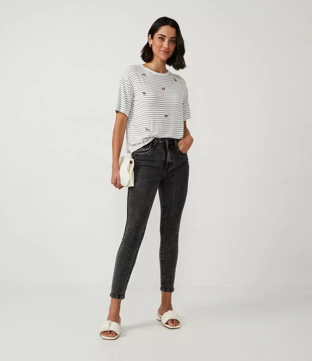

image 1 | describe:
caption: the model wears the jeans and a white t - shirt
prompt:  Question: What is she wearing? Answer:
A white tee shirt and black jeans
prompt:  Question: What is the color of the shirt? Answer:
Grey
prompt:  Question: What is the shirt color? Answer:
Grey
prompt:  Question: What is the color of the jeans? Answer:
Grey
prompt:  Question: What is the color of the pants? Answer:
Grey
prompt:  Question: Describe the shirt details? Answer:
The shirt has a white and grey striped design
prompt:  Question: What are the shirt details? Answer:
The shirt details are the buttons and the
prompt:  Question: What are the jeans details? Answer:
The jeans are made of a stretchy denim


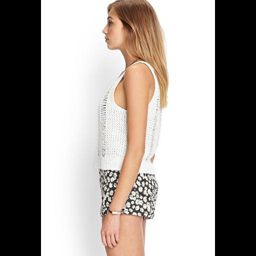

image 2 | describe:
caption: the back of a woman wearing a white tank top and shorts
prompt:  Question: What is she wearing? Answer:
A white crochet tank top and black shorts
prompt:  Question: What is the color of the shirt? Answer:
White
prompt:  Question: What is the shirt color? Answer:
White
prompt:  Question: What is the color of the pants? Answer:
White
prompt:  Question: Describe the shirt details? Answer:
The shirt is a knitted top with a scoop neckline and a
prompt:  Question: What are the shirt details? Answer:
The shirt details are the sleeves, the neckline, the back, the collar, the hem, the sleeves, the neckline, the collar,
prompt:  Question: What are the short details? Answer:
The short details are the side cutouts, the back cutouts, the back pockets, the back straps, the back straps, the back straps,


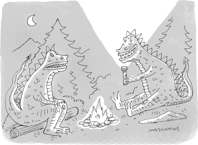

image 3 | describe:
caption: two cartoon monsters sitting around a campfire
prompt:  Question: What is the dinosaur holding? Answer:
A torch
prompt:  this is a cartoon of
two monsters sitting around a campfire
prompt:  they look like they are
having a conversation


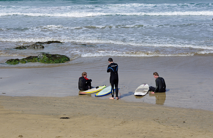

image 4 | describe:
caption: three people sitting on the beach with surfboards
prompt:  Question: Why are they standing around? Answer:
Because they are waiting for the waves to come in


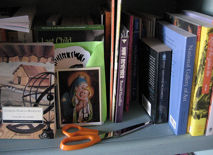

image 5 | describe:
caption: a book shelf with a pair of scissors and a book
prompt:  Question: What color is the book on the far right? Answer:
Orange


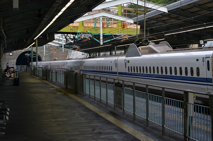

image 6 | describe:
caption: a train is pulling into a station with people on the platform
prompt:  Question: Is this a modern train? Answer:
Yes


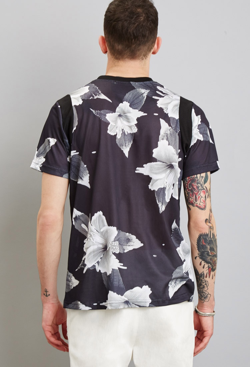

test image 5 | describe:
caption: the back of a man wearing a black and white floral print t - shirt
prompt:  Question: What is he wearing? Answer:
A black and white floral print t - shirt
prompt:  Question: What is the color of the shirt? Answer:
Black
prompt:  Question: What is the color of the pants? Answer:
Black
prompt:  Question: Describe the shirt? Answer:
The shirt is black and white with a floral print on the front and back
prompt:  Question: What are the shirt details? Answer:
The shirt is made of a polyester/cotton blend and features a floral print on the front and back
prompt:  Question: What are the pants details? Answer:
The pants are made of a stretchy fabric that is designed to fit the body and the legs


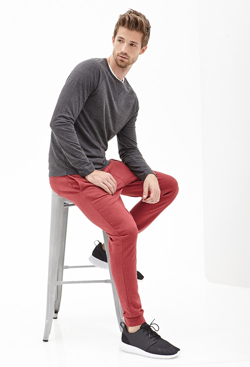

image 6 | describe:
caption: a man sitting on a stool wearing red pants
prompt:  Question: What is he wearing? Answer:
A pair of jeans and a sweater
prompt:  Question: What is the color of the shirt? Answer:
Red
prompt:  Question: What is the shirt color? Answer:
Red
prompt:  Question: What is the color of the pants? Answer:
Red
prompt:  Question: Describe the shirt? Answer:
The shirt is a grey sweater with a red and black striped pattern
prompt:  Question: What are the shirt details? Answer:
The shirt details are the collar, cuffs, and hem.
prompt:  Question: What are the pants details? Answer:
The pants are made of 100% cotton and have a relaxed fit.


In [ ]:
teste_imagens()

# Train the model

In [ ]:
notebook_login()

Epoch: 0
Average Epoch Loss: 4.890625  || indx 0
time  1.669111728668213
Average Epoch Loss: 0.6080266225361777  || indx 500
time  778.790634393692
epoch loss:
0.535507225093985


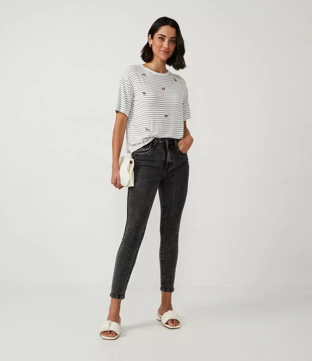

image 1 | describe:
caption: The T-shirt this person wears has short sleeves and its fabric is cotton. The pattern of it is graphic. It has a crew neckline. This person wears a long trousers, with denim fabric and solid color patterns. There is an accessory on
prompt:  Question: What is she wearing? Answer:
The T-shirt the person wears has short sleeves and its fabric is cotton. The pattern of it is graphic. It has a lapel neckline
prompt:  Question: What is the color of the shirt? Answer:
It is a short-sleeve shirt with graphic patterns. The shirt is with cotton fabric. The neckline of the shirt is crew. There is
prompt:  Question: What is the shirt color? Answer:
It is a short-sleeve shirt with pure color patterns. The shirt has a round neckline. The pants the lady wears is of long length
prompt:  Question: What is the color of the jeans? Answer:
The jeans are of long length. The jeans are with cotton fabric and graphic patterns. There is an accessory on her wrist. There is an access

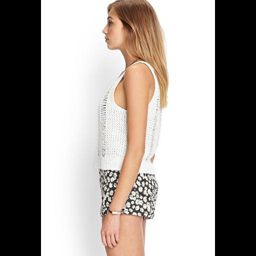

image 2 | describe:
caption: The tank shirt this person wears has sleeves cut off and its fabric is cotton. The pattern of it is graphic. It has a suspenders neckline. This person wears a three-point pants, with cotton fabric and graphic patterns. There is an
prompt:  Question: What is she wearing? Answer:
The tank top the person wears has no sleeves and its fabric is cotton. The person wears a three-point pants, with cotton fabric and other patterns
prompt:  Question: What is the color of the shirt? Answer:
It is a tank shirt with pure color patterns. The tank shirt is with knitting fabric. The pants the lady wears is of three-point length.
prompt:  Question: What is the shirt color? Answer:
It is a sleeveless shirt with pure color patterns. The shirt is with knitting fabric. The neckline of the shirt is suspenders. The
prompt:  Question: What is the color of the pants? Answer:
It is a white cotton fabric and its pattern is pure color. The neckline of the pants is crew. The pants are 

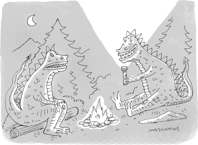

image 3 | describe:
caption: The cartoon depicts two people sitting on a log and drinking beer. The person on the log is holding a bottle of beer. The person on the log is holding a bottle of wine. The person on the log is holding a bottle of beer. The
prompt:  Question: What is the dinosaur holding? Answer:
A bottle of wine. This cartoon was published in the magazine The New Yorker. The author is Mark Danner. The cartoon is in the style of
prompt:  this is a cartoon of
two people sitting on a log, with a fire in the middle, and a tree in the background. The person on the left is holding a bottle
prompt:  they look like they are
having a conversation about something. The person on the left has a bottle of wine in his hand. The person on the right has a beer in his


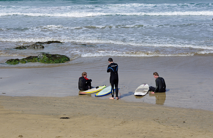

image 4 | describe:
caption: The three people are standing on the beach with surfboards in their hands. The men are wearing black swimsuits. The water is shallow. The men are wearing gloves. The men are wearing sandals. The three people are wearing wetsuits.
prompt:  Question: Why are they standing around? Answer:
Because they are on a beach. The beach is a body of water. The water is a body of water. The people are wearing swimsuits.


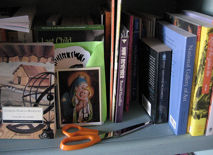

image 5 | describe:
caption: The book is in the middle of the shelf
prompt:  Question: What color is the book on the far right? Answer:
Black. The book is a book. The book is a book. The book is a book. The book is a book. The book is a


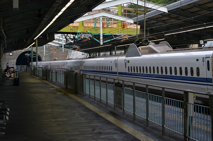

image 6 | describe:
caption: The train is parked in a station with a large number of people. The train is with a white color. The train is with a blue color. The train is with a white color. The train is with a black color. The train is with
prompt:  Question: Is this a modern train? Answer:
Yes. This is a modern train. It is a long train. The train is in the middle of the road. The train has a lot of


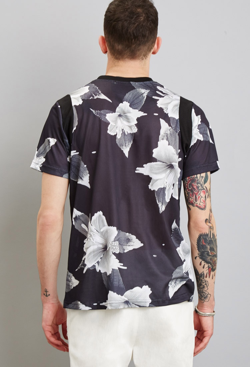

test image 5 | describe:
caption: The shirt this guy wears has short sleeves and its fabric is cotton. The pattern of it is floral.
prompt:  Question: What is he wearing? Answer:
The T-shirt the person wears has short sleeves and its fabric is cotton. The pattern of it is graphic.
prompt:  Question: What is the color of the shirt? Answer:
It is a short-sleeve shirt with floral patterns. The shirt is with cotton fabric. There is an accessory on his wrist.
prompt:  Question: What is the color of the pants? Answer:
The color of the pants is pure color. The pants are with cotton fabric and graphic patterns.
prompt:  Question: Describe the shirt? Answer:
The shirt is with cotton fabric and graphic patterns.
prompt:  Question: What are the shirt details? Answer:
The shirt has short sleeves, cotton fabric and graphic patterns.
prompt:  Question: What are the pants details? Answer:
They are the T-shirts with graphic patterns. The T-shirts are with cotton fabric. The neckline of the T-shirts is

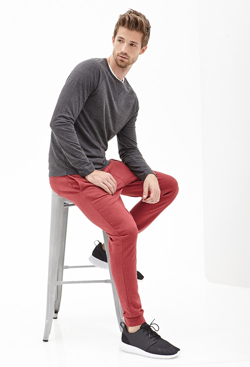

image 6 | describe:
caption: The sweater this man wears has long sleeves and it is with cotton fabric and solid color patterns. The neckline of the sweater is crew. The pants this man wears is of long length. The pants are with cotton fabric and solid color patterns. There
prompt:  Question: What is he wearing? Answer:
This person is wearing a long-sleeve sweater with solid color patterns. The sweater is with cotton fabric. It has a round neckline. The
prompt:  Question: What is the color of the shirt? Answer:
It is gray. The shirt is with cotton fabric and its neckline is lapel. The person wears a ring.
prompt:  Question: What is the shirt color? Answer:
It is a long-sleeve shirt with solid color patterns. The shirt is with cotton fabric and its neckline is lapel.
prompt:  Question: What is the color of the pants? Answer:
The pants are of cotton fabric and their neckline is round. The outer clothing is of cotton fabric and pure color patterns.
prompt:  Question: Describe the shirt? An

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Epoch: 1
Average Epoch Loss: 0.316162109375  || indx 0
time  1393.4306902885437
Average Epoch Loss: 0.29407883451846306  || indx 500
time  2165.1871480941772
epoch loss:
0.2909849697485902


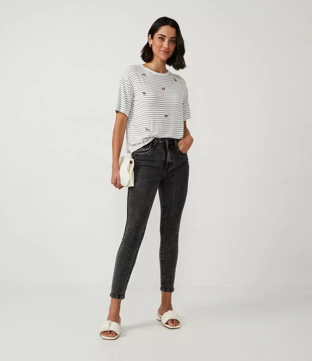

image 1 | describe:
caption: The T-shirt the person wears has short sleeves, its fabric is cotton, and it has graphic patterns. The T-shirt has a crew neckline. The person wears a long trousers, with denim fabric and pure color patterns. There is an
prompt:  Question: What is she wearing? Answer:
The T-shirt the lady wears has short sleeves and its fabric is cotton. The pattern of it is pure color. The lady wears a long trousers
prompt:  Question: What is the color of the shirt? Answer:
The shirt is with cotton fabric and graphic patterns. The neckline of the shirt is crew. The female is wearing a ring on her finger.
prompt:  Question: What is the shirt color? Answer:
The shirt the lady wears has short sleeves and it is with cotton fabric and graphic patterns. The neckline of the shirt is crew. The lady wears
prompt:  Question: What is the color of the jeans? Answer:
The T-shirt has short sleeves, cotton fabric and graphic patterns. The neckline of the T-shirt is round. The jeans are w

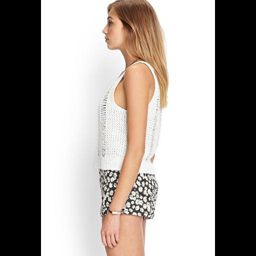

image 2 | describe:
caption: The upper clothing has sleeves cut off, knitting fabric and pure color patterns. The lower clothing is of three-point length. The fabric is cotton and it has graphic patterns. There is an accessory on her wrist.
prompt:  Question: What is she wearing? Answer:
The tank top the female wears has no sleeves and it is with knitting fabric and solid color patterns. The female wears a three-point shorts, with
prompt:  Question: What is the color of the shirt? Answer:
It is a tank tank shirt with knit fabric. The neckline of the tank shirt is crew. The pants the lady wears is of three-point
prompt:  Question: What is the shirt color? Answer:
It is with cotton fabric and graphic patterns. The female wears a three-point shorts. The shorts are with cotton fabric and floral patterns. There is
prompt:  Question: What is the color of the pants? Answer:
The pants are with cotton fabric and graphic patterns. The neckline of the pants is suspenders. There is an accessory on

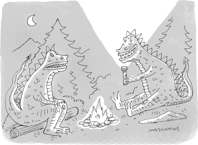

image 3 | describe:
caption: The two dragons are having a conversation about the weather. The first one says, "I'm having a conversation with my friend about the weather." The second one says, "I'm having a conversation with my friend about the weather." The first dragon
prompt:  Question: What is the dinosaur holding? Answer:
A torch. This is a cartoon. The cartoonist is named John C. Dvorak. The dinosaur is named Dori. The cartoonist
prompt:  this is a cartoon of
two dinosaurs having a conversation about the weather. the first one is a dragon and the other is a t-rex. the two are having a conversation
prompt:  they look like they are
having a conversation about the weather. The conversation is about the weather. The two people are having a conversation about the weather. The conversation is about the


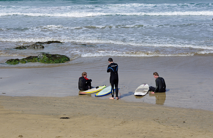

image 4 | describe:
caption: The people are wearing wet suits and have their hair in a bun. The people are wearing black sunglasses. The people are wearing a hat. The person is wearing a ring on his finger. The person has a beard. The person has a hat.
prompt:  Question: Why are they standing around? Answer:
They are standing around because they are in the water. The water is the ocean. The surfers are in the water. The surfers are in


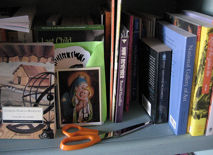

image 5 | describe:
caption: The books on the shelf are stacked in a row. The books are all in the same format. The books are in a plastic case. The case is in a plastic case. The books are in a plastic case. The books are in a plastic
prompt:  Question: What color is the book on the far right? Answer:
The book is "The Catcher in the Rye" by J.D. Salinger. The cover of the book is a picture of a cat


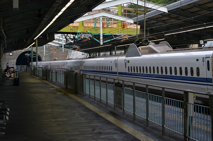

image 6 | describe:
caption: The train is parked in the station. The train has a blue stripe. The train is with a white stripe. The train is with a red stripe. The train is with a white stripe. The train is with a blue stripe. The train is
prompt:  Question: Is this a modern train? Answer:
Yes. It is a high-speed train. It is called the Shinkansen. The train is in Japan. The train is in the station


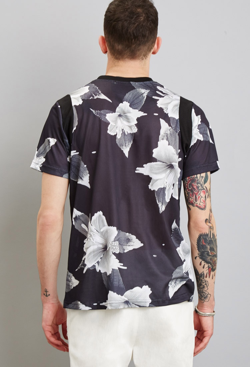

test image 5 | describe:
caption: The shirt this gentleman wears has short sleeves and it is with cotton fabric and graphic patterns. There is an accessory on his wrist.
prompt:  Question: What is he wearing? Answer:
The shirt the person wears has short sleeves and it is with cotton fabric and graphic patterns. There is an accessory on his wrist.
prompt:  Question: What is the color of the shirt? Answer:
The shirt is with cotton fabric and graphic patterns. The neckline of the shirt is crew.
prompt:  Question: What is the color of the pants? Answer:
The T-shirt the person wears is of short length. The pants are with cotton fabric and graphic patterns. There is a ring on his finger.
prompt:  Question: Describe the shirt? Answer:
The shirt the person wears has short sleeves and it is with cotton fabric and graphic patterns.
prompt:  Question: What are the shirt details? Answer:
The shirt this man wears has short sleeves and it is with cotton fabric and graphic patterns. There is an acces

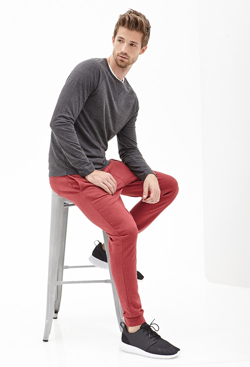

image 6 | describe:
caption: The sweater the person wears has long sleeves and it is with cotton fabric and pure color patterns. The neckline of the sweater is round. The person wears a long trousers, with cotton fabric and solid color patterns.
prompt:  Question: What is he wearing? Answer:
His shirt has long sleeves, cotton fabric and solid color patterns. It has a round neckline. This person wears a long pants. The pants are
prompt:  Question: What is the color of the shirt? Answer:
It is a long-sleeve shirt with solid color patterns. The shirt is with cotton fabric. It has a crew neckline. The pants the
prompt:  Question: What is the shirt color? Answer:
Gray. The shirt is long and its fabric is cotton. It has a round neckline. The outer clothing the person wears is with cotton fabric and
prompt:  Question: What is the color of the pants? Answer:
It is a solid color of pure color. The neckline of the pants is lapel. The person is wearing a hat.
prompt:  Question: Describe the shirt

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Epoch: 2
Average Epoch Loss: 0.29443359375  || indx 0
time  2799.858471393585
Average Epoch Loss: 0.26688200746943613  || indx 500
time  3594.2833886146545
epoch loss:
0.2672388980263158


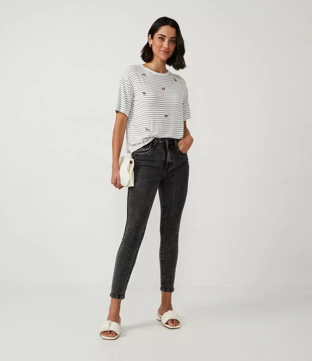

image 1 | describe:
caption: The T-shirt this woman wears has short sleeves and its fabric is cotton. The pattern of it is graphic. It has a crew neckline. This woman wears a long trousers, with denim fabric and solid color patterns. The female wears a ring
prompt:  Question: What is she wearing? Answer:
The T-shirt with graphic patterns. The T-shirt is with cotton fabric. It has a crew neckline. The pants the lady wears is
prompt:  Question: What is the color of the shirt? Answer:
It is in cotton fabric and it has graphic patterns. The neckline of the shirt is round. The pants the lady wears is of long length.
prompt:  Question: What is the shirt color? Answer:
The shirt is of short length. The shirt has a crew neckline. The pants the person wears is of long length. The pants are with denim
prompt:  Question: What is the color of the jeans? Answer:
The jeans are with denim fabric and pure color patterns. The neckline of the jeans is round. There is an accessory on her wrist.
prompt:  

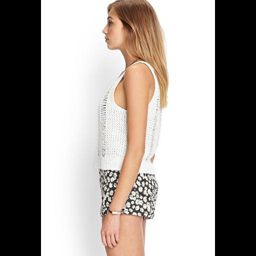

image 2 | describe:
caption: The tank top this woman wears has no sleeves and it is with knitting fabric and graphic patterns. This woman wears a three-point shorts, with cotton fabric and graphic patterns. There is an accessory on her wrist. There is an accessory in his her
prompt:  Question: What is she wearing? Answer:
The tank tank top with graphic patterns. The shorts the lady wears is of three-point length. The shorts are with cotton fabric and graphic patterns.
prompt:  Question: What is the color of the shirt? Answer:
Red. The shirt is with knitting fabric. The shorts the lady wears is of three-point length. The shorts are with cotton fabric and graphic patterns
prompt:  Question: What is the shirt color? Answer:
Red. The shirt is with cotton fabric. The shorts the lady wears is of three-point length. The shorts are with cotton fabric and graphic patterns
prompt:  Question: What is the color of the pants? Answer:
The pants are with cotton fabric and graphic patterns. The person

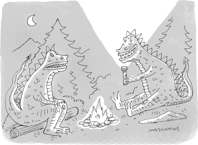

image 3 | describe:
caption: The cartoonist draws a fire and a table with a glass of wine. The table has a tablecloth and a fire. The cartoonist draws a pot of tea. The tea is on a plate. The plate has a ring. The cartoonist
prompt:  Question: What is the dinosaur holding? Answer:
A torch. The torch is used to light the fire. The torch is used to heat the fire. The dinosaur is holding a knife. The knife
prompt:  this is a cartoon of
two people having a conversation in the woods. The conversation is about a fire. The fire is in the middle of the conversation. The conversation is about
prompt:  they look like they are
having a conversation


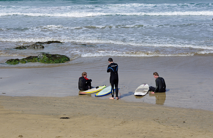

image 4 | describe:
caption: The water is clear and the sky is blue. The people are wearing wetsuits. The wetsuits are with leather. The people are wearing hats. The water is with a wave. The people are wearing sunglasses. The people are wearing sunglasses
prompt:  Question: Why are they standing around? Answer:
The water is very cold. The water is very cold. The water is very cold. The water is very cold. The water is very cold.


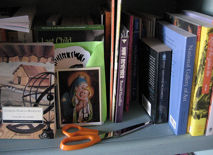

image 5 | describe:
caption: The book is on the shelf
prompt:  Question: What color is the book on the far right? Answer:
Red


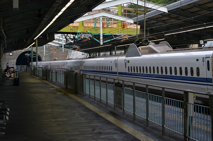

image 6 | describe:
caption: The train is parked at the station. The train has a white stripe on the side. The train has a large window on the side. The train has a roof over it. The train has a metal roof. The train has a guard rail on
prompt:  Question: Is this a modern train? Answer:
Yes


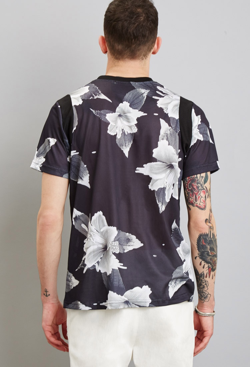

test image 5 | describe:
caption: The shirt this guy wears has short sleeves and its fabric is cotton. The pattern of it is graphic. There is an accessory on his wrist. This man has neckwear.
prompt:  Question: What is he wearing? Answer:
The shirt with graphic patterns. The shirt is with cotton fabric. There is an accessory on his wrist.
prompt:  Question: What is the color of the shirt? Answer:
The shirt is in cotton fabric. The neckline of the shirt is round. There is an accessory on his wrist.
prompt:  Question: What is the color of the pants? Answer:
The pants are with cotton fabric and graphic patterns.
prompt:  Question: Describe the shirt? Answer:
The shirt is with cotton fabric and graphic patterns. There is an accessory on his wrist.
prompt:  Question: What are the shirt details? Answer:
The shirt is with cotton fabric and graphic patterns. The neckline of the shirt is crew.
prompt:  Question: What are the pants details? Answer:
The pants are of short length. The pants are wi

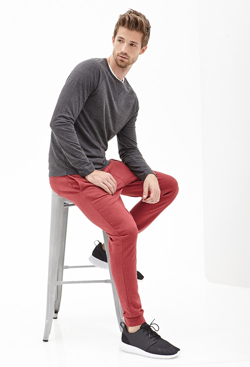

image 6 | describe:
caption: The sweater this gentleman wears has long sleeves and it is with cotton fabric and pure color patterns. The neckline of the sweater is crew. This gentleman wears a long pants, with cotton fabric and pure color patterns. The person is wearing a ring on
prompt:  Question: What is he wearing? Answer:
His shirt is long-sleeve sweater with pure color patterns. The sweater is with cotton fabric. It has a round neckline. The pants the
prompt:  Question: What is the color of the shirt? Answer:
It is in cotton fabric and it has pure color patterns. The neckline of the shirt is crew. The pants the guy wears is of long length
prompt:  Question: What is the shirt color? Answer:
It is cotton fabric. It has solid color patterns. It has a round neckline. The person wears a long pants. The pants are with cotton
prompt:  Question: What is the color of the pants? Answer:
It is "solid color". The pants are of long length. The pants are of long length. The pants are of cotton 

adapter_model.safetensors:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

In [ ]:
import time

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

device = "cuda" if torch.cuda.is_available() else "cpu"
a=time.time()
model.train()
for epoch in range(3):
  print("Epoch:", epoch)
  aver_epoch_loss=[]
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device, torch.float16)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss
    aver_epoch_loss.append(loss.item())
    if idx % 500 ==0:
      print("Average Epoch Loss:", sum(aver_epoch_loss)/len(aver_epoch_loss),' || indx',idx)
      b=time.time()
      print('time ',b-a)
    loss.backward()

    optimizer.step()
    optimizer.zero_grad()
  print('epoch loss:')
  print(sum(aver_epoch_loss)/len(aver_epoch_loss))
  teste_imagens()
  if epoch == 0:
    model.push_to_hub("leoreigoto/Data2_V2_BLIP2_Finetune_Caption_First_Epoch", use_temp_dir=True)
  else:
    model.push_to_hub("leoreigoto/Data2_V2_Blip2_Finetune_Caption")

# Load from the Hub

In [ ]:
peft_model_id = "leoreigoto/Data2_V2_BLIP2_Finetune_Caption_First_Epoch"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, load_in_8bit=True, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")